In [1]:
import pandas as pd
import numpy as np
from functions import *
from models import *
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# set default plotting parameters
plt.rcParams.update({'font.size': 12, 'figure.figsize': (10, 4), 'figure.dpi': 300})


%load_ext autoreload
%autoreload 2

**Table of contents**<a id='toc0_'></a>    
- [Create simulated values](#toc1_)    
- [Estimate models with simulated data](#toc2_)    
  - [OLS](#toc2_1_)    
    - [Linear model](#toc2_1_1_)    
    - [Non-normal model](#toc2_1_2_)    
    - [Non-linear model](#toc2_1_3_)    
  - [LASSO (OLS)](#toc2_2_)    
    - [Linear model](#toc2_2_1_)    
    - [Non-normal model](#toc2_2_2_)    
    - [Non-linear model](#toc2_2_3_)    
  - [MLP](#toc2_3_)    
    - [General setup](#toc2_3_1_)    
    - [Linear model](#toc2_3_2_)    
      - [Setup](#toc2_3_2_1_)    
      - [Training](#toc2_3_2_2_)    
      - [Prediction](#toc2_3_2_3_)    
    - [Non-normal model](#toc2_3_3_)    
      - [Setup](#toc2_3_3_1_)    
    - [Non-linear model](#toc2_3_4_)    
      - [Setup](#toc2_3_4_1_)    
      - [Training](#toc2_3_4_2_)    
      - [Prediction](#toc2_3_4_3_)    
- [Results](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Create simulated values](#toc0_)

In [2]:
# load raw data
data = pd.read_csv('data/data.csv')

# financials[(financials['ticker'] == 'INVb.CO^F05')]
baspread = data[(data['ticker'] == 'NOVOb.CO')]['baspread'].values *100
mom12m = data[(data['ticker'] == 'NOVOb.CO')]['mom12m'].values * 100
mom6m = data[(data['ticker'] == 'NOVOb.CO')]['mom6m'].values * 100
mom3m = data[(data['ticker'] == 'NOVOb.CO')]['mom3m'].values * 100
mom1m = data[(data['ticker'] == 'NOVOb.CO')]['mom1m'].values * 100
baspread_large = data[(data['ticker'] == 'MAERSKb.CO') | (data['ticker']=='NOVOb.CO') | (data['ticker']=='CARLb.CO')]['baspread']*100
# remove outliers
baspread_large = baspread_large[(baspread_large < 1)]

In [3]:
np.random.seed(42)
theta = 3
lambda_ = 0.05
datapoints = 100
datapoints_train = int(datapoints * 0.7)

# create simulations
x = baspread[-datapoints:]
# x_outofsample = baspread[100:200]

# linear
y1 = theta * x + np.random.normal(0, 0.01, len(x))
y1_train = y1[:datapoints_train]
y1_test = y1[datapoints_train:]

# non-normal error
y2 = theta * x + np.random.standard_t(1, len(x)) * 0.01
y2_train = y2[:datapoints_train]
y2_test = y2[datapoints_train:]


# non-linear
y3 = theta**3 * x**2 + np.abs(x-lambda_) + np.random.normal(0, 0.01, len(x))
y3_train = y3[:datapoints_train]
y3_test = y3[datapoints_train:]

# make x 2 dimensional
x = x.reshape(-1, 1)

# create noise features
n_noise = 5
noise = (x/4 + np.random.normal(0, np.std(x), size=(len(x), n_noise)))

# add constant term
x = np.concatenate((np.ones((len(x), 1)), x), axis=1)
x_noise = np.concatenate((x, noise), axis=1)


# split data
x_train_noise = x_noise[:datapoints_train]
x_test_noise = x_noise[datapoints_train:]
x_train = x[:datapoints_train]
x_test = x[datapoints_train:]



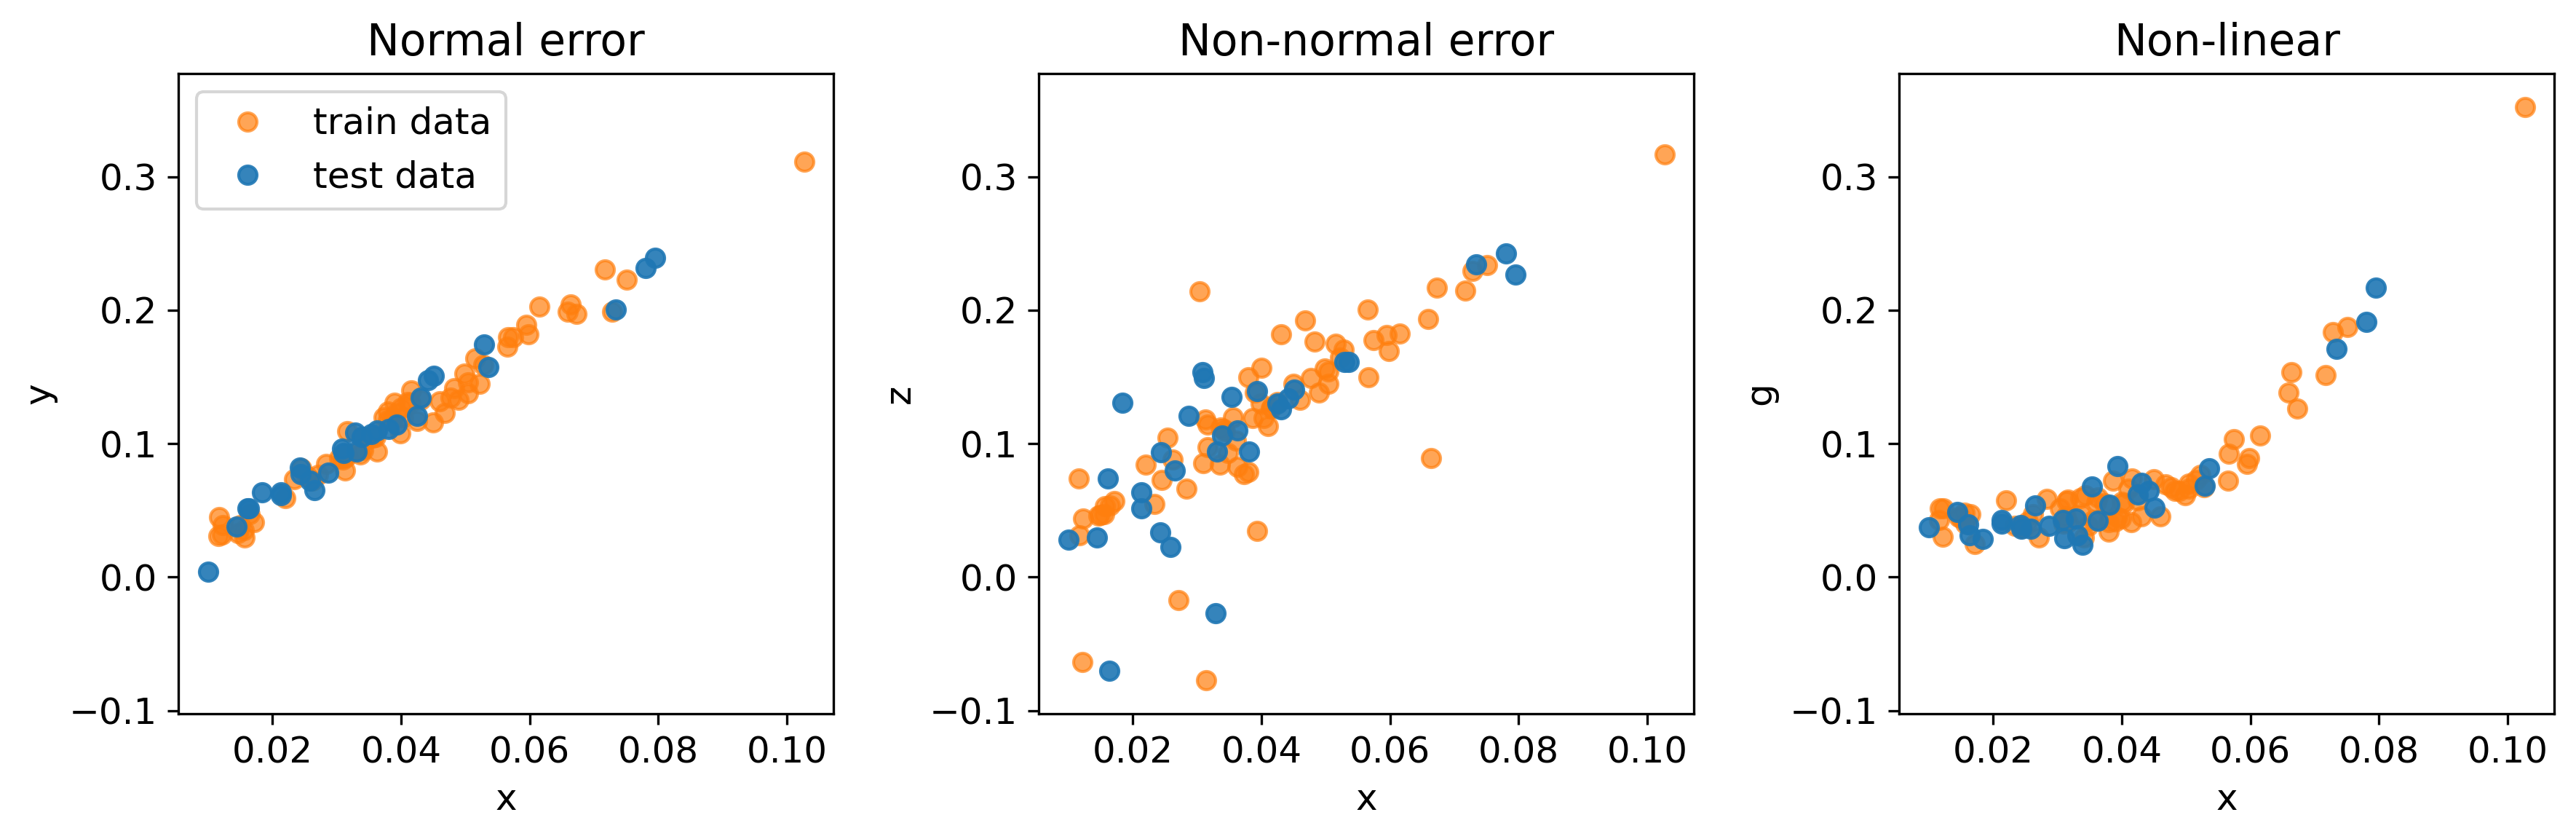

In [4]:
all_y = np.concatenate([y1_train, y1_test, y2_train, y2_test, y3_train, y3_test])
y_min, y_max = all_y.min()-0.025, all_y.max()+0.025
fig = plt.figure(figsize=(12, 4))

# plot the simulations
plt.subplot(1, 3, 1)
plt.plot(x_train[:,1], y1_train, 'o', label='train data', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.legend(loc='upper left')
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal error')

plt.subplot(1, 3, 2)
plt.plot(x_train[:,1], y2_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Non-normal error')

plt.subplot(1, 3, 3)
plt.plot(x_train[:,1], y3_train, 'o', label='train', color='C1', alpha=0.7)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
plt.title('Non-linear')

plt.tight_layout()
plt.savefig('output/simulation-data.png', dpi=300)
plt.show()
plt.close()

# <a id='toc2_'></a>[Estimate models with simulated data](#toc0_)

## <a id='toc2_1_'></a>[OLS](#toc0_)

### <a id='toc2_1_1_'></a>[Linear model](#toc0_)

In [5]:
# linear model
# estimate the parameters
ols_est1 = estimate(y1_train,x_train)

# for i in ols_est1:
#     print(i, ols_est1[i])

print(ols_est1['b_hat'])
print(ols_est1['se'])

ols_pred1 = ols_est1['b_hat'] @ x_test.T

[-0.00521934  3.09651467]
[[0.00265834]
 [0.06072498]]


### <a id='toc2_1_2_'></a>[Non-normal model](#toc0_)

In [6]:
# linear model
# estimate the parameters
ols_est2 = estimate(y2_train,x_train)

print(ols_est2['b_hat'])
print(ols_est2['se'])

ols_pred2 = ols_est2['b_hat'] @ x_test.T

[-0.00516583  3.10081345]
[[0.01170021]
 [0.26727014]]


### <a id='toc2_1_3_'></a>[Non-linear model](#toc0_)

In [7]:
# non-linear model
# estimate the parameters
ols_est3 = estimate(y3_train,x_train)

print(ols_est3['b_hat'])
print(ols_est3['se'])

ols_pred3 = ols_est3['b_hat'] @ x_test.T

[-0.02037604  2.2135834 ]
[[0.00843472]
 [0.19267578]]


### Noise models

In [8]:
# estimate the parameters and predict
ols_est1n = estimate(y1_train,x_train_noise)
print(ols_est1n['b_hat'])
ols_pred1_n = ols_est1n['b_hat'] @ x_test_noise.T

[-0.00466228  3.08821799 -0.05204827 -0.02016497  0.15569886 -0.10464405
  0.07429813]


In [9]:
# estimate the parameters and predict
ols_est2n = estimate(y2_train,x_train_noise)
print(ols_est2n['b_hat'])
ols_pred2_n = ols_est2n['b_hat'] @ x_test_noise.T

[-0.00965566  3.1843241   0.19361211 -0.26536603  0.05316847  0.28366116
 -0.27264084]


In [10]:
# estimate the parameters and predict
ols_est3n = estimate(y3_train,x_train_noise)
print(ols_est3n['b_hat'])
ols_pred3_n = ols_est3n['b_hat'] @ x_test_noise.T

[-0.0212394   2.14598812  0.17733118  0.02799865 -0.02906691  0.10019078
  0.03877331]


## <a id='toc2_2_'></a>[LASSO](#toc0_)

### <a id='toc2_2_1_'></a>[Linear model](#toc0_)

In [11]:
# linear model
# create a grid using numpy.geomspace
penalty_grid = np.geomspace(1e-10, 10, num = 10000)

# estimate the model using LassoCV
fit_CV1 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y1_train)

# # investigate the penalty
# penalty_CV1 = fit_CV1.alpha_ 
# print('Penalty_CV: ', penalty_CV1)

# investigate the coefficients
coeff_CV1 = fit_CV1.coef_
print('Coefficients: ', coeff_CV1)

lasso_pred1 = fit_CV1.predict(x_test)

Coefficients:  [0.         3.09651434]


### <a id='toc2_2_2_'></a>[Non-normal model](#toc0_)

In [12]:
# estimate the model using LassoCV
fit_CV2 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y2_train)

# # investigate the penalty
# penalty_CV2 = fit_CV2.alpha_ 
# print('Penalty_CV: ', penalty_CV2)

# investigate the coefficients
coeff_CV2 = fit_CV2.coef_
print('Coefficients: ', coeff_CV2)

lasso_pred2 = fit_CV2.predict(x_test)

Coefficients:  [0.         3.04002087]


### <a id='toc2_2_3_'></a>[Non-linear model](#toc0_)

In [13]:
# estimate the model using LassoCV
fit_CV3 = LassoCV(cv=5, alphas=penalty_grid).fit(x_train,y3_train)

# # investigate the penalty
# penalty_CV3 = fit_CV3.alpha_ 
# print('Penalty_CV: ', penalty_CV3)

# investigate the coefficients
coeff_CV = fit_CV3.coef_
print('Coefficients: ', coeff_CV)

lasso_pred3 = fit_CV3.predict(x_test)

Coefficients:  [0.         2.21358307]


### Noise models

In [14]:
# estimate the model using LassoCV
fit_CV1n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y1_train)
# investigate the penalty
penalty_CV1n = fit_CV1n.alpha_ 
print('Penalty_CV: ', penalty_CV1n)

# Investigate the coefficients
coeff_CV1n = fit_CV1n.coef_
print('Coefficients: ', coeff_CV1n)
lasso_pred1_n = fit_CV1n.predict(x_test_noise)

Penalty_CV:  3.809413230471342e-06
Coefficients:  [ 0.00000000e+00  3.06696856e+00 -3.82905160e-02 -7.27828116e-04
  1.43243594e-01 -8.54046407e-02  6.56899927e-02]


In [15]:
# estimate the model using LassoCV
fit_CV2n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y2_train)
# investigate the penalty
penalty_CV2n = fit_CV2n.alpha_ 
print('Penalty_CV: ', penalty_CV2n)

# Investigate the coefficients
coeff_CV2n = fit_CV2n.coef_
print('Coefficients: ', coeff_CV2n)
lasso_pred2_n = fit_CV2n.predict(x_test_noise)

Penalty_CV:  8.967993184401919e-05
Coefficients:  [ 0.          2.79991453  0.         -0.          0.          0.03702526
 -0.        ]


In [16]:
# estimate the model using LassoCV
fit_CV3n = LassoCV(cv=5, alphas=penalty_grid).fit(x_train_noise,y3_train)
# investigate the penalty
penalty_CV3n = fit_CV3n.alpha_ 
print('Penalty_CV: ', penalty_CV3n)

# Investigate the coefficients
coeff_CV3n = fit_CV3n.coef_
print('Coefficients: ', coeff_CV3n)
lasso_pred3_n = fit_CV3n.predict(x_test_noise)

Penalty_CV:  5.0080651155633145e-05
Coefficients:  [ 0.          2.04229029  0.05478578  0.         -0.          0.
  0.        ]


## <a id='toc2_3_'></a>[MLP](#toc0_)

### <a id='toc2_3_1_'></a>[General setup](#toc0_)

In [17]:
# remove constant as bias is included in the model
scaler_x, scaler_y1, scaler_y2, scaler_y3 = StandardScaler(), StandardScaler(), StandardScaler(), StandardScaler()
x_train_mlp = scaler_x.fit_transform(x_train[:,1][:9*(datapoints_train//10)].reshape(-1, 1))
x_val_mlp = scaler_x.transform(x_train[:,1][9*(datapoints_train//10):].reshape(-1, 1))
x_test_mlp = scaler_x.transform(x_test[:,1].reshape(-1, 1))

y1_train_mlp = scaler_y1.fit_transform(y1_train[:9*(datapoints_train//10)].reshape(-1, 1))
y1_val_mlp = scaler_y1.transform(y1_train[9*(datapoints_train//10):].reshape(-1, 1))
y1_test_mlp = scaler_y1.transform(y1_test.reshape(-1, 1))

y2_train_mlp = scaler_y2.fit_transform(y2_train[:9*(datapoints_train//10)].reshape(-1, 1))
y2_val_mlp = scaler_y2.transform(y2_train[9*(datapoints_train//10):].reshape(-1, 1))
y2_test_mlp = scaler_y2.transform(y2_test.reshape(-1, 1))

y3_train_mlp = scaler_y3.fit_transform(y3_train[:9*(datapoints_train//10)].reshape(-1, 1))
y3_val_mlp = scaler_y3.transform(y3_train[9*(datapoints_train//10):].reshape(-1, 1))
y3_test_mlp = scaler_y3.transform(y3_test.reshape(-1, 1))

In [18]:
# moving to metal or CUDA GPU if available
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Using device:", device)

# general hyperparameters
input_dim = x_train_mlp.shape[1]
hidden_depth = 1 # excluding output layer
hidden_width = 2 # int for all being equal width; list for different widths
learning_rate = 1e-2 # increased from 1e-3 as we have full batching
activation_fun = nn.ReLU # nn.ReLU nn.Tanh nn.Sigmoid nn.LeakyReLU nn.Identity

# general critereon and regularization parameters
criterion = nn.MSELoss()
lambda_l1 = 0 # 1e-4
lambda_l2 = 0 # 1e-4

# general parmeters
patience = 2000
print_freq = 250
epochs = 2000
batch_size = len(x_train_mlp) # full batching as we have a small dataset

Using device: mps


### <a id='toc2_3_2_'></a>[Linear model](#toc0_)

In [19]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y1_val_mlp)
best_model1, _ = train_mlp(train_dataset,
          val_dataset,
          model1,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1 = predict_mlp(best_model1, 
                        x_test_mlp, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 2.62582E-02  - Val Loss: 2.44308E-02
Epoch 500/2000  - Train Loss: 2.32190E-02  - Val Loss: 2.91966E-02
Epoch 750/2000  - Train Loss: 2.30670E-02  - Val Loss: 3.10352E-02
Epoch 1000/2000  - Train Loss: 2.30526E-02  - Val Loss: 3.13092E-02
Epoch 1250/2000  - Train Loss: 2.24743E-02  - Val Loss: 3.09823E-02
Epoch 1500/2000  - Train Loss: 2.24629E-02  - Val Loss: 3.10631E-02
Epoch 1750/2000  - Train Loss: 2.24631E-02  - Val Loss: 3.10604E-02
Epoch 2000/2000  - Train Loss: 2.24630E-02  - Val Loss: 3.10693E-02


### <a id='toc2_3_3_'></a>[Non-normal model](#toc0_)


In [20]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y2_val_mlp)
best_model2, _ = train_mlp(train_dataset,
          val_dataset,
          model2,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2 = predict_mlp(best_model2, 
                        x_test_mlp, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 3.45360E-01  - Val Loss: 9.55527E-02
Epoch 500/2000  - Train Loss: 3.40873E-01  - Val Loss: 8.95876E-02
Epoch 750/2000  - Train Loss: 3.40921E-01  - Val Loss: 8.94059E-02
Epoch 1000/2000  - Train Loss: 3.40891E-01  - Val Loss: 8.94341E-02
Epoch 1250/2000  - Train Loss: 3.40884E-01  - Val Loss: 8.98093E-02
Epoch 1500/2000  - Train Loss: 3.40916E-01  - Val Loss: 9.02052E-02
Epoch 1750/2000  - Train Loss: 3.40889E-01  - Val Loss: 8.99088E-02
Epoch 2000/2000  - Train Loss: 3.40899E-01  - Val Loss: 8.97877E-02


### <a id='toc2_3_4_'></a>[Non-linear model](#toc0_)

In [21]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3 = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp, y3_val_mlp)
best_model3, _ = train_mlp(train_dataset,
          val_dataset,
          model3,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred3 = predict_mlp(best_model3, 
                        x_test_mlp, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 4.80559E-02  - Val Loss: 1.98496E-02
Epoch 500/2000  - Train Loss: 4.68590E-02  - Val Loss: 2.03855E-02
Epoch 750/2000  - Train Loss: 4.65149E-02  - Val Loss: 1.92366E-02
Epoch 1000/2000  - Train Loss: 4.38760E-02  - Val Loss: 1.78726E-02
Epoch 1250/2000  - Train Loss: 4.30598E-02  - Val Loss: 2.66310E-02
Epoch 1500/2000  - Train Loss: 4.30597E-02  - Val Loss: 2.66238E-02
Epoch 1750/2000  - Train Loss: 4.30597E-02  - Val Loss: 2.66236E-02
Epoch 2000/2000  - Train Loss: 4.30597E-02  - Val Loss: 2.66236E-02


## Noise models

In [22]:
# remove constant as bias is included in the model
scaler_x = StandardScaler()
x_train_mlp_n = scaler_x.fit_transform(x_train_noise[:,1:][:9*(datapoints_train//10)])
x_val_mlp_n = scaler_x.transform(x_train_noise[:,1:][9*(datapoints_train//10):])
x_test_mlp_n = scaler_x.transform(x_test_noise[:,1:])

### Without regularization

In [23]:
# update input_dim to match the the noise features
input_dim = x_train_mlp_n.shape[1]

In [24]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y1_val_mlp)
best_model1_n, _ = train_mlp(train_dataset,
          val_dataset,
          model1_n,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1_n = predict_mlp(best_model1_n, 
                        x_test_mlp_n, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 3.08247E-02  - Val Loss: 6.34155E-02
Epoch 500/2000  - Train Loss: 2.42571E-02  - Val Loss: 4.71183E-02
Epoch 750/2000  - Train Loss: 1.70280E-02  - Val Loss: 5.07892E-02
Epoch 1000/2000  - Train Loss: 1.67042E-02  - Val Loss: 4.87305E-02
Epoch 1250/2000  - Train Loss: 1.66968E-02  - Val Loss: 4.87544E-02
Epoch 1500/2000  - Train Loss: 1.66899E-02  - Val Loss: 4.86857E-02
Epoch 1750/2000  - Train Loss: 1.66831E-02  - Val Loss: 4.87474E-02
Epoch 2000/2000  - Train Loss: 1.66768E-02  - Val Loss: 4.88809E-02


In [25]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y2_val_mlp)
best_model2_n, _ = train_mlp(train_dataset,
          val_dataset,
          model2_n,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2_n = predict_mlp(best_model2_n, 
                        x_test_mlp_n, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 2.85894E-01  - Val Loss: 1.71079E-01
Epoch 500/2000  - Train Loss: 2.80992E-01  - Val Loss: 1.76894E-01
Epoch 750/2000  - Train Loss: 2.79177E-01  - Val Loss: 1.82374E-01
Epoch 1000/2000  - Train Loss: 2.79127E-01  - Val Loss: 1.82267E-01
Epoch 1250/2000  - Train Loss: 2.79164E-01  - Val Loss: 1.83233E-01
Epoch 1500/2000  - Train Loss: 2.79107E-01  - Val Loss: 1.83064E-01
Epoch 1750/2000  - Train Loss: 2.79213E-01  - Val Loss: 1.83538E-01
Epoch 2000/2000  - Train Loss: 2.79194E-01  - Val Loss: 1.83733E-01


In [26]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3_n = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y3_val_mlp)
best_model3_n, _ = train_mlp(train_dataset,
          val_dataset,
          model3_n,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred3_n = predict_mlp(best_model3_n, 
                        x_test_mlp_n, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 3.63945E-02  - Val Loss: 3.27452E-02
Epoch 500/2000  - Train Loss: 3.61519E-02  - Val Loss: 3.33681E-02
Epoch 750/2000  - Train Loss: 3.60330E-02  - Val Loss: 3.40436E-02
Epoch 1000/2000  - Train Loss: 3.59432E-02  - Val Loss: 3.46385E-02
Epoch 1250/2000  - Train Loss: 3.49740E-02  - Val Loss: 3.76427E-02
Epoch 1500/2000  - Train Loss: 3.47904E-02  - Val Loss: 3.80259E-02
Epoch 1750/2000  - Train Loss: 3.47146E-02  - Val Loss: 3.89726E-02
Epoch 2000/2000  - Train Loss: 3.39241E-02  - Val Loss: 4.03090E-02


### With regularization

In [27]:
# update parameters of the model
lambda_l1 = 1e-2
lambda_l2 = 1e-2

In [28]:
# linear model
np.random.seed(42)
torch.manual_seed(42)
model1_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y1_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y1_val_mlp)
best_model1_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model1_nR,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred1_nR = predict_mlp(best_model1_nR, 
                        x_test_mlp_n, 
                        y1_test_mlp, 
                        scaler_y1,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 3.57563E-02  - Val Loss: 5.60442E-02
Epoch 500/2000  - Train Loss: 2.42393E-02  - Val Loss: 6.12925E-02
Epoch 750/2000  - Train Loss: 2.26228E-02  - Val Loss: 5.68001E-02
Epoch 1000/2000  - Train Loss: 2.17252E-02  - Val Loss: 5.95986E-02
Epoch 1250/2000  - Train Loss: 2.11400E-02  - Val Loss: 5.26300E-02
Epoch 1500/2000  - Train Loss: 2.11494E-02  - Val Loss: 5.26490E-02
Epoch 1750/2000  - Train Loss: 2.11110E-02  - Val Loss: 5.26910E-02
Epoch 2000/2000  - Train Loss: 2.10936E-02  - Val Loss: 5.27091E-02


In [29]:
# non-normal model
np.random.seed(42)
torch.manual_seed(42)
model2_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y2_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y2_val_mlp)
best_model2_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model2_nR,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred2_nR = predict_mlp(best_model2_nR, 
                        x_test_mlp_n, 
                        y2_test_mlp, 
                        scaler_y2,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 2.91939E-01  - Val Loss: 1.70116E-01
Epoch 500/2000  - Train Loss: 2.87349E-01  - Val Loss: 1.73145E-01
Epoch 750/2000  - Train Loss: 2.85142E-01  - Val Loss: 1.80204E-01
Epoch 1000/2000  - Train Loss: 2.85026E-01  - Val Loss: 1.79756E-01
Epoch 1250/2000  - Train Loss: 2.84942E-01  - Val Loss: 1.80923E-01
Epoch 1500/2000  - Train Loss: 2.84915E-01  - Val Loss: 1.80863E-01
Epoch 1750/2000  - Train Loss: 2.84783E-01  - Val Loss: 1.79097E-01
Epoch 2000/2000  - Train Loss: 2.84688E-01  - Val Loss: 1.80506E-01


In [30]:
# non-linear model
np.random.seed(42)
torch.manual_seed(42)
model3_nR = MLPModel(input_dim,depth=hidden_depth,width=hidden_width, activation=activation_fun).to(device)
train_dataset = MLPdataset(x_train_mlp_n, y3_train_mlp)
val_dataset = MLPdataset(x_val_mlp_n, y3_val_mlp)
best_model3_nR, _ = train_mlp(train_dataset,
          val_dataset,
          model3_nR,
          criterion,
          learning_rate,
          lambda_l1,
          lambda_l2,
          epochs,
          patience,
          print_freq,
          device,
          batch_size=batch_size,
          shuffle_train=True,
          shuffle_val=False)

mlp_pred3_nR = predict_mlp(best_model3_nR, 
                        x_test_mlp_n, 
                        y3_test_mlp, 
                        scaler_y3,
                        batch_size=None,
                        device=device)

Epoch 250/2000  - Train Loss: 4.27016E-02  - Val Loss: 3.23685E-02
Epoch 500/2000  - Train Loss: 4.25065E-02  - Val Loss: 3.30011E-02
Epoch 750/2000  - Train Loss: 4.24076E-02  - Val Loss: 3.32873E-02
Epoch 1000/2000  - Train Loss: 4.23232E-02  - Val Loss: 3.36888E-02
Epoch 1250/2000  - Train Loss: 4.22553E-02  - Val Loss: 3.38695E-02
Epoch 1500/2000  - Train Loss: 4.22193E-02  - Val Loss: 3.39097E-02
Epoch 1750/2000  - Train Loss: 4.22060E-02  - Val Loss: 3.41827E-02
Epoch 2000/2000  - Train Loss: 4.22110E-02  - Val Loss: 3.42515E-02


# <a id='toc3_'></a>[Results](#toc0_)

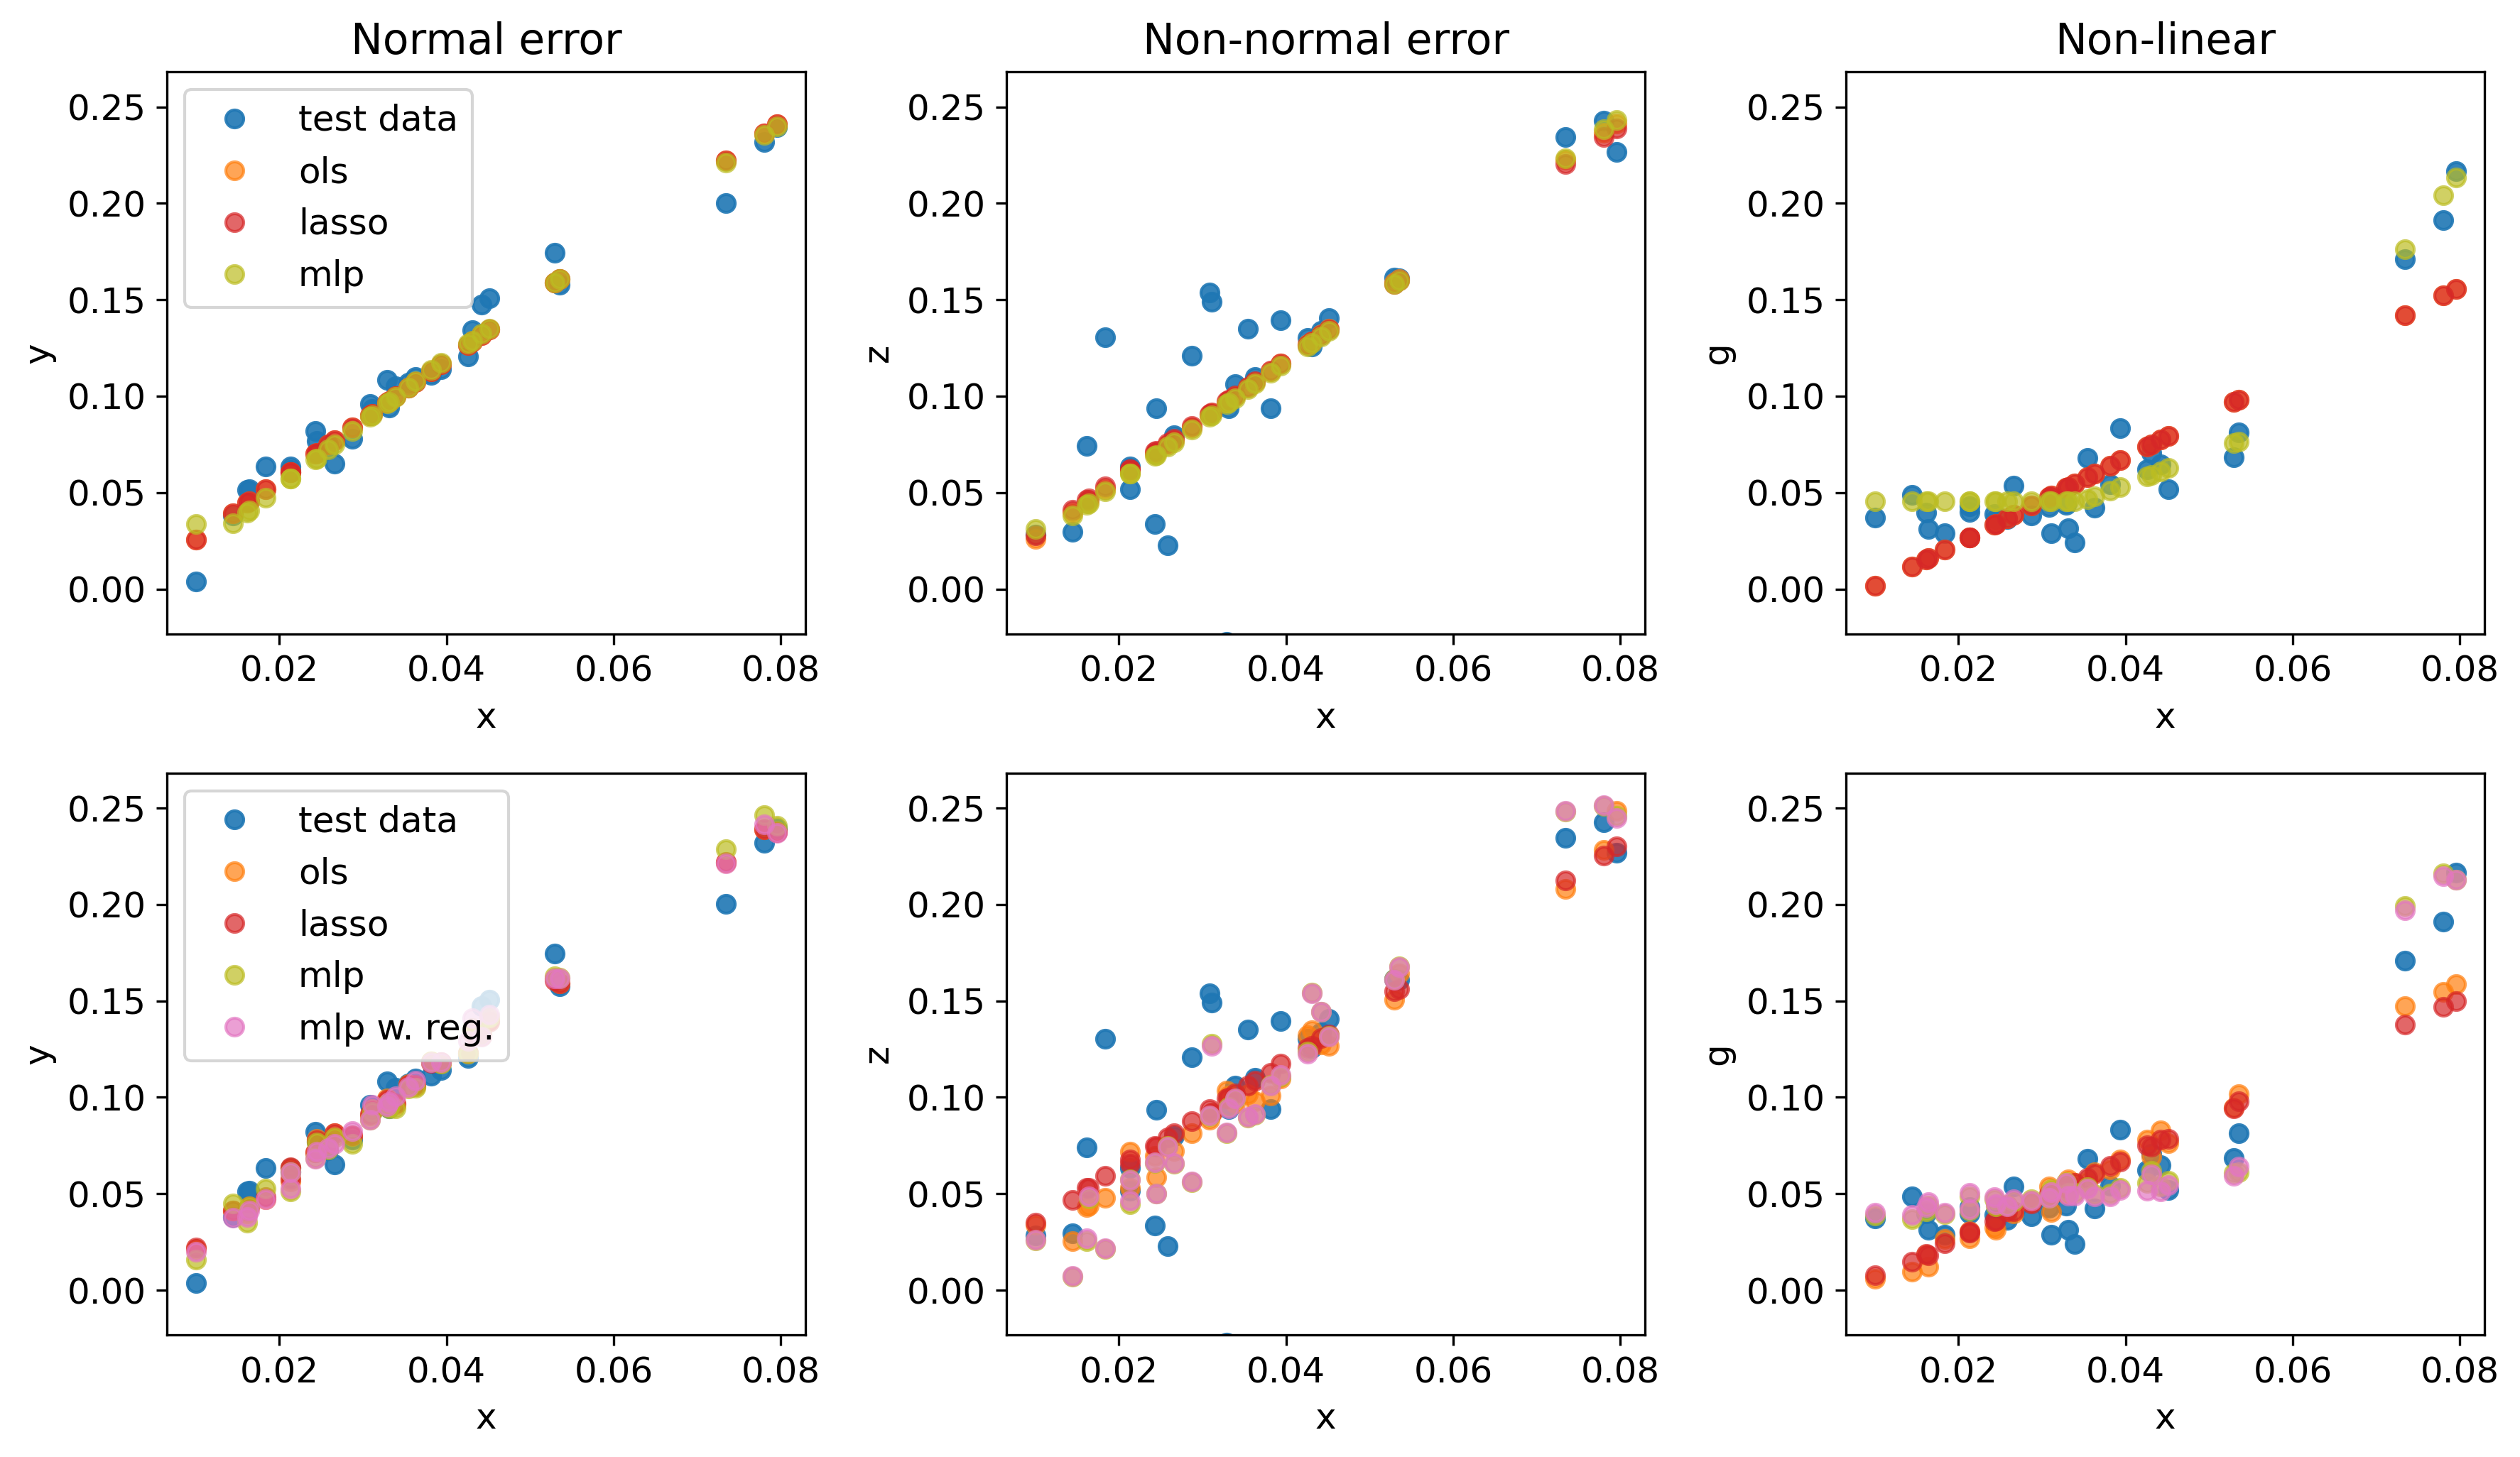

In [31]:
all_y = np.concatenate([y1_test, ols_pred1, lasso_pred1, mlp_pred1,
                        ols_pred2, lasso_pred2, mlp_pred2,
                        ols_pred3, lasso_pred3, mlp_pred3])
y_min, y_max = all_y.min()-0.025, all_y.max()+0.025

# set figure size
fig = plt.figure(figsize=(12, 7))

# plot the simulations
plt.subplot(2, 3, 1)
plt.plot(x_test[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred1, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred1, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred1, 'o', label='mlp', color='C8', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Normal error')

plt.subplot(2, 3, 2)
plt.plot(x_test[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred2, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred2, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred2, 'o', label='mlp', color='C8', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
plt.title('Non-normal error')

plt.subplot(2, 3, 3)
plt.plot(x_test[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test[:,1], ols_pred3, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test[:,1], lasso_pred3, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test[:,1], mlp_pred3, 'o', label='mlp',  color='C8', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
plt.title('Non-linear')

plt.subplot(2, 3, 4)
plt.plot(x_test_noise[:,1], y1_test, 'o', label='test data', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred1_n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred1_n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred1_n, 'o', label='mlp', color='C8', alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred1_nR, 'o', label='mlp w. reg.', color='C6', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.legend(loc='upper left')
# plt.legend(loc='upper left')
plt.xlabel('x')
plt.ylabel('y')
# plt.title('Normal error')

plt.subplot(2, 3, 5)
plt.plot(x_test_noise[:,1], y2_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred2_n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred2_n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred2_n, 'o', label='mlp', color='C8', alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred2_nR, 'o', label='mlp w. reg.', color='C6', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('z')
# plt.title('Non-normal error')

plt.subplot(2, 3, 6)
plt.plot(x_test_noise[:,1], y3_test, 'o', label='test', color='C0', alpha=0.9)
plt.plot(x_test_noise[:,1], ols_pred3_n, 'o', label='ols', color='C1', alpha=0.7)
plt.plot(x_test_noise[:,1], lasso_pred3_n, 'o', label='lasso', color='C3',  alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred3_n, 'o', label='mlp',  color='C8', alpha=0.7)
plt.plot(x_test_noise[:,1], mlp_pred3_nR, 'o', label='mlp w. reg.',  color='C6', alpha=0.7)
# plt.yticks(np.arange(-0.1, 0.5, 0.05))
plt.ylim(y_min, y_max)
plt.xlabel('x')
plt.ylabel('g')
# plt.title('Non-linear')
# plt.suptitle('Simulations with noise')
plt.tight_layout()
plt.savefig('output/simulation-scatter.png')
plt.show()
plt.close()

In [32]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y1, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred1, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred1, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred1, label='mlp', color='C8', alpha=0.7)

plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)

plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear.png', dpi=300)
# plt.show()
plt.close()

In [33]:
n_train = np.arange(len(x_train))
n_test  = np.arange(len(x_train), len(x))
n_full  = np.arange(len(x))

plt.plot(n_full, y2, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred2, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred2, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred2, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Linear Data Generating Process w. non-normal error")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/linear-non-normal.png', dpi=300)
# plt.show()
plt.close()

In [34]:
plt.plot(n_full, y3, label='y', color='C0', alpha=0.9)
# plt.plot(n_full, x[:,1], label='x', color='C6', alpha=0.7)

plt.plot(n_test, ols_pred3, label='ols', color='C1', alpha=0.7)
plt.plot(n_test, lasso_pred3, label='lasso', color='C3',  alpha=0.7)
plt.plot(n_test, mlp_pred3, label='mlp', color='C8', alpha=0.7)
plt.axvline(len(x_train), color='k', linestyle='--', alpha=0.6)
plt.legend(loc='upper left')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Non-linear Data Generating Process")
plt.ylim(y_min, y_max)
plt.tight_layout()
plt.savefig('output/non-linear-simul.png', dpi=300)
# plt.show()
plt.close()

In [35]:
# calculate the root mean squared error for each
rmse_ols1 = np.sqrt(np.mean((y1_test - ols_pred1)**2))
rmse_lasso1 = np.sqrt(np.mean((y1_test - lasso_pred1)**2))
rmse_mlp1 = np.sqrt(np.mean((y1_test - mlp_pred1)**2))

rmse_ols2 = np.sqrt(np.mean((y2_test - ols_pred2)**2))
rmse_lasso2 = np.sqrt(np.mean((y2_test - lasso_pred2)**2))
rmse_mlp2 = np.sqrt(np.mean((y2_test - mlp_pred2)**2))

rmse_ols3 = np.sqrt(np.mean((y3_test - ols_pred3)**2))
rmse_lasso3 = np.sqrt(np.mean((y3_test - lasso_pred3)**2))
rmse_mlp3 = np.sqrt(np.mean((y3_test - mlp_pred3)**2))

# calculate mean absolute error
mae_ols1 = np.mean(np.abs(y1_test - ols_pred1))
mae_lasso1 = np.mean(np.abs(y1_test - lasso_pred1))
mae_mlp1 = np.mean(np.abs(y1_test - mlp_pred1))

mae_ols2 = np.mean(np.abs(y2_test - ols_pred2))
mae_lasso2 = np.mean(np.abs(y2_test - lasso_pred2))
mae_mlp2 = np.mean(np.abs(y2_test - mlp_pred2))

mae_ols3 = np.mean(np.abs(y3_test - ols_pred3))
mae_lasso3 = np.mean(np.abs(y3_test - lasso_pred3))
mae_mlp3 = np.mean(np.abs(y3_test - mlp_pred3))

models = ['OLS', 'LASSO', 'MLP']
metrics = {'*RMSE*Normal error':[rmse_ols1, rmse_lasso1, rmse_mlp1],
           '*RMSE*Non-normal error':[rmse_ols2, rmse_lasso2, rmse_mlp2],
           '*RMSE*Non-linear':[rmse_ols3, rmse_lasso3, rmse_mlp3],
           '*MAE*Normal error':[mae_ols1, mae_lasso1, mae_mlp1],
           '*MAE*Non-normal error':[mae_ols2, mae_lasso2, mae_mlp2],
           '*MAE*Non-linear':[mae_ols3, mae_lasso3, mae_mlp3]}

tab = latex_table_grouped(models,metrics)

# print(tab)
with open('output/simulation_table.tex', 'w') as f:
    f.write(tab)
